In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
import galstreams

from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline

import emcee
from multiprocessing import Pool
import corner
import pickle
from itertools import cycle

%matplotlib inline

In [4]:
plt.style.use('notebook_tex')

## Definitions

In [5]:
ham = gp.Hamiltonian(gp.MilkyWayPotential())
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [6]:
dt = 0.5 * u.Myr

def ln_likelihood(p, ra_0, data, n_steps, dt, wangle):
    # initial conditions at ra_0
    dec, d, pm1, pm2, vr = p
    
    if (d<0) | (np.abs(vr)>500) | (dec<-90) | (dec>90):
        return -np.inf
    
    _phi2_sigma = 0. # deg
    _dist_sigma = 0. # kpc
    _vr_sigma = 0 # km/s
    _pm_sigma = 0 # mas/yr
    
    wdeg = wangle.to(u.deg).value
    
    c = coord.ICRS(ra=ra_0*u.deg, dec=dec*u.deg, distance=d*u.kpc, 
               pm_ra_cosdec=pm1*u.mas/u.yr,
               pm_dec=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)

    w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
    if ham.energy(w0)>0:
        return -np.inf
    
    orbit = ham.integrate_orbit(w0, dt=dt, n_steps=n_steps)
    model_stream = orbit.to_coord_frame(coord.ICRS, galactocentric_frame=gc_frame)
    model_x = model_stream.ra.wrap_at(wangle).degree
    if model_x[-1] < wdeg - 360:
        return -np.inf
    
    model_phi2 = model_stream.dec.degree
    model_dist = model_stream.distance.to(u.kpc).value
    model_pmra = model_stream.pm_ra_cosdec.to(u.mas/u.yr).value
    model_pmdec = model_stream.pm_dec.to(u.mas/u.yr).value
    ix = np.argsort(model_x)
    model_x = model_x[ix]
    
    # define interpolating functions
    order = 3
    bbox = [wdeg - 360, wdeg]
    chi2 = 0
    
    phi2_interp = InterpolatedUnivariateSpline(model_x, model_phi2[ix], k=order, bbox=bbox)
    dist_interp = InterpolatedUnivariateSpline(model_x, model_dist[ix], k=order, bbox=bbox)
    pmra_interp = InterpolatedUnivariateSpline(model_x, model_pmra[ix], k=order, bbox=bbox)
    pmdec_interp = InterpolatedUnivariateSpline(model_x, model_pmdec[ix], k=order, bbox=bbox)
  
    phi2_sigma = np.sqrt(_phi2_sigma**2 + data['phi2'][2]**2)
    chi2 += np.sum(-(phi2_interp(data['phi2'][0]) - data['phi2'][1])**2 / phi2_sigma**2 - 2*np.log(phi2_sigma))
    
    dist_sigma = np.sqrt(_dist_sigma**2 + data['dist'][2]**2)
    chi2 += np.sum(-(dist_interp(data['dist'][0]) - data['dist'][1])**2 / dist_sigma**2 - 2*np.log(dist_sigma))
    
    pmra_sigma = np.sqrt(_pm_sigma**2 + data['pmra'][2]**2)
    chi2 += np.sum(-(pmra_interp(data['pmra'][0]) - data['pmra'][1])**2 / pmra_sigma**2 - 2*np.log(pmra_sigma))
    
    pmdec_sigma = np.sqrt(_pm_sigma**2 + data['pmdec'][2]**2)
    chi2 += np.sum(-(pmdec_interp(data['pmdec'][0]) - data['pmdec'][1])**2 / pmdec_sigma**2 - 2*np.log(pmdec_sigma))
    
    return chi2

In [7]:
class HandlerTupleVert(HandlerBase):
    """
    Handler for Tuple.

    Additional kwargs are passed through to `HandlerBase`.

    Parameters
    ----------
    ndivide : int, optional
        The number of sections to divide the vertical legend area into. If None,
        use the length of the input tuple. Default is 1.


    pad : float, optional
        If None, fall back to ``legend.borderpad`` as the default.
        In units of fraction of font size. Default is None.
    """
    def __init__(self, ndivide=1, pad=None, **kwargs):

        self._ndivide = ndivide
        self._pad = pad
        HandlerBase.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):

        handler_map = legend.get_legend_handler_map()

        if self._ndivide is None:
            ndivide = len(orig_handle)
        else:
            ndivide = self._ndivide

        if self._pad is None:
            pad = legend.borderpad * fontsize
        else:
            pad = self._pad * fontsize

        if ndivide > 1:
            height = (height - pad*(ndivide - 1)) / ndivide
#             width = (width - pad * (ndivide - 1)) / ndivide

#         xds_cycle = cycle(xdescent - (width + pad) * np.arange(ndivide))
        yds_cycle = cycle(ydescent - (height + pad) * (np.arange(ndivide)+0.5*(ndivide-1)))

        a_list = []
        for handle1 in orig_handle:
            handler = legend.get_legend_handler(handler_map, handle1)
            _a_list = handler.create_artists(
                legend, handle1,
                xdescent, next(yds_cycle), width, height, fontsize, trans)
#                 next(xds_cycle), ydescent, width, height, fontsize, trans)
            a_list.extend(_a_list)

        return a_list

## Read data

In [8]:
tc = Table.read('../data/stream_endpoints_5d.fits')

In [9]:
tall = Table.read('../data/stream_fits_5d.fits')

In [10]:
for i in range(5,6):
    name = tall['name'][i]
    # load chain
    sampler = pickle.load(open('../data/sampler_{:s}.pkl'.format(name), 'rb'))
    print('{:s} facc = {:.2f}'.format(name, np.median(sampler.acceptance_fraction)))
    chain = sampler.chain[:,256:,:]
    flatchain = np.reshape(chain,(-1,5))

    # subsample
    np.random.seed(391)
    nsample = 1000
    flatchain_short = np.random.permutation(flatchain)[:nsample,:]

    # stream observations
    ra0 = tall['ra0'][i]
    n_steps = tall['n_steps'][i]
    wangle = tall['wangle'][i]*u.deg
    data = {}
    data['phi2'] = tall['phi2'][i]
    data['dist'] = tall['dist'][i]
    data['pmra'] = tall['pmra'][i]
    data['pmdec'] = tall['pmdec'][i]

Fj\"{o}rm facc = 0.56


## Generate models and orbits

In [11]:
nplot = 20
models = []
orbits = []
n_steps_long = int((5*u.Gyr/dt).decompose())

for j in range(nplot):
    dec, d, pm1, pm2, vr = flatchain_short[j]
    c = coord.ICRS(ra=ra0*u.deg, dec=dec*u.deg, distance=d*u.kpc, 
                   pm_ra_cosdec=pm1*u.mas/u.yr,
                   pm_dec=pm2*u.mas/u.yr,
                   radial_velocity=vr*u.km/u.s)
    w0_stream = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

    fit_orbit = ham.integrate_orbit(w0_stream, dt=dt, n_steps=n_steps)
    model_stream = fit_orbit.to_coord_frame(coord.ICRS, galactocentric_frame=gc_frame)
    models += [model_stream]
    
    orbit_fwd = ham.integrate_orbit(w0_stream, dt=dt, n_steps=n_steps_long)
    orbits += [orbit_fwd]

## Plot

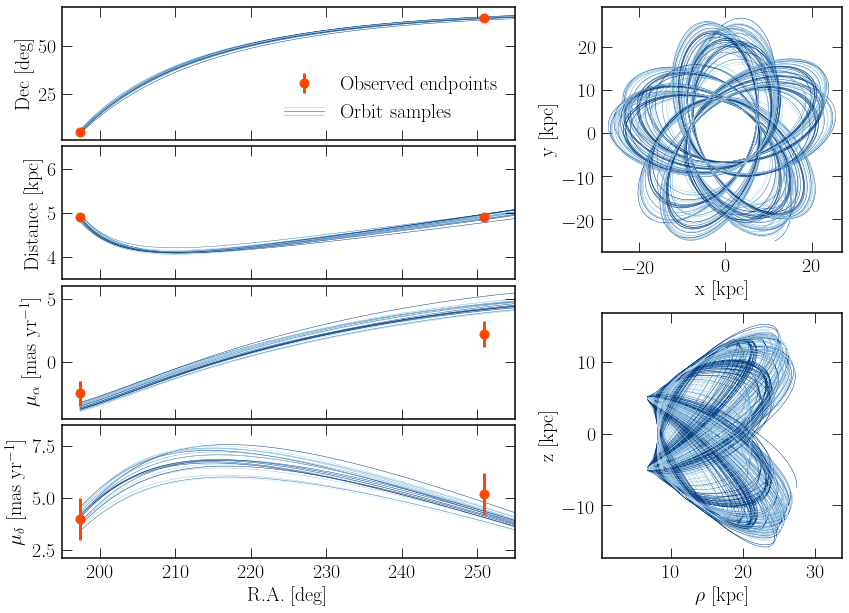

In [13]:
f = 1.1
fig = plt.figure(figsize=(11*f,8*f))
gs1 = mpl.gridspec.GridSpec(4,1)
gs1.update(left=0.08, right=0.6, top=0.95, bottom=0.08, hspace=0.05)

gs2 = mpl.gridspec.GridSpec(2,1)
gs2.update(left=0.7, right=0.975, top=0.95, bottom=0.08, hspace=0.25)

ax0 = fig.add_subplot(gs1[0])
ax1 = fig.add_subplot(gs1[1], sharex=ax0)
ax2 = fig.add_subplot(gs1[2], sharex=ax0)
ax3 = fig.add_subplot(gs1[3], sharex=ax0)
ax4 = fig.add_subplot(gs2[0])
ax5 = fig.add_subplot(gs2[1])
ax = [ax0, ax1, ax2, ax3, ax4, ax5]

# Observed coordinates -- short orbits
# left side

np.random.seed(748)
colors = mpl.cm.Blues(np.random.rand(nplot))
lw = 0.5

for j in range(nplot):
    model = models[j]
    color = colors[j]

    plt.sca(ax[0])
    plt.plot(model.ra.wrap_at(wangle), model.dec, '-', color=color, lw=lw, zorder=0, label='Orbit samples')
    
    plt.sca(ax[1])
    plt.plot(model.ra.wrap_at(wangle), model.distance, '-', color=color, lw=lw, zorder=0)

    plt.sca(ax[2])
    plt.plot(model.ra.wrap_at(wangle), model.pm_ra_cosdec, '-', color=color, lw=lw, zorder=0)

    plt.sca(ax[3])
    plt.plot(model.ra.wrap_at(wangle), model.pm_dec, '-', color=color, lw=lw, zorder=0)

color_data = 'orangered'
data_cols = ['phi2', 'dist', 'pmra', 'pmdec']

for e, cname in enumerate(data_cols):
    plt.sca(ax[e])
    plt.errorbar(data[cname][0], data[cname][1], yerr=data[cname][2], color=color_data, fmt='o', ms=9, lw=3,
                label='Observed endpoints')

plt.sca(ax[0])
plt.ylabel('Dec [deg]')
plt.xlim(195, 255)

handles, labels = plt.gca().get_legend_handles_labels()
h_ = [handles[-1], tuple([handles[1], handles[0], handles[2]])]
l_ = [labels[-1], labels[0]]
plt.legend(h_, l_, fontsize='medium', frameon=False, loc=4,
           handler_map={tuple: HandlerTupleVert(ndivide=None, pad=0.5)})

plt.sca(ax[1])
plt.ylabel('Distance [kpc]')
plt.ylim(3.5, 6.5)

plt.sca(ax[2])
plt.ylabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylim(-4.5, 6)

plt.sca(ax[3])
plt.xlabel('R.A. [deg]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')
plt.ylim(2.1, 8.5)

# Galactocentric coordinates -- long orbits
# right side

for j in range(nplot):
    orbit = orbits[j]
    color = colors[j]

    plt.sca(ax[4])
    plt.plot(orbit.cartesian.x, orbit.cartesian.y, '-', color=color, lw=lw)
    
    plt.sca(ax[5])
    plt.plot(orbit.cylindrical.rho, orbit.cartesian.z, '-', color=color, lw=lw)
    
plt.sca(ax[4])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.sca(ax[5])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('$\\rho$ [kpc]')
plt.ylabel('z [kpc]')

plt.savefig('../paper/figures/stream_fitting.pdf')

### Develop two sides of the figure

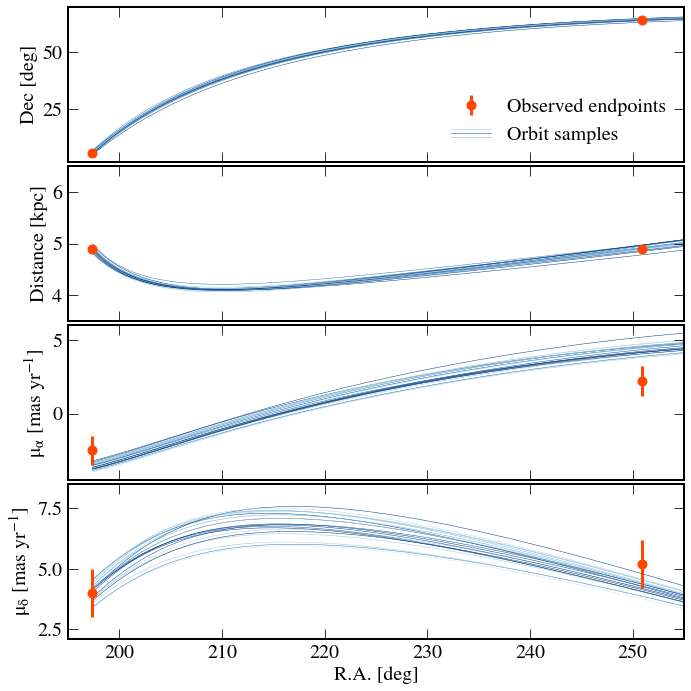

In [11]:
fig, ax = plt.subplots(4,1,figsize=(10,10), sharex=True)
np.random.seed(748)
lw = 0.5

for j in range(nplot):
    model = models[j]
    color = mpl.cm.Blues(np.random.random())

    plt.sca(ax[0])
    plt.plot(model.ra.wrap_at(wangle), model.dec, '-', color=color, lw=lw, zorder=0, label='Orbit samples')
    
    plt.sca(ax[1])
    plt.plot(model.ra.wrap_at(wangle), model.distance, '-', color=color, lw=lw, zorder=0)

    plt.sca(ax[2])
    plt.plot(model.ra.wrap_at(wangle), model.pm_ra_cosdec, '-', color=color, lw=lw, zorder=0)

    plt.sca(ax[3])
    plt.plot(model.ra.wrap_at(wangle), model.pm_dec, '-', color=color, lw=lw, zorder=0)

    
color_data = 'orangered'
data_cols = ['phi2', 'dist', 'pmra', 'pmdec']
pdata = []

for e, cname in enumerate(data_cols):
    plt.sca(ax[e])
    plt.errorbar(data[cname][0], data[cname][1], yerr=data[cname][2], color=color_data, fmt='o', ms=9, lw=3,
                label='Observed endpoints')

plt.sca(ax[0])
plt.ylabel('Dec [deg]')
plt.xlim(195, 255)

handles, labels = plt.gca().get_legend_handles_labels()
h_ = [handles[-1], tuple([handles[1], handles[0], handles[2]])]
l_ = [labels[-1], labels[0]]
plt.legend(h_, l_, fontsize='medium', frameon=False, loc=4,
           handler_map={tuple: HandlerTupleVert(ndivide=None, pad=0.5)})

plt.sca(ax[1])
plt.ylabel('Distance [kpc]')
plt.ylim(3.5, 6.5)

plt.sca(ax[2])
plt.ylabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylim(-4.5, 6)

plt.sca(ax[3])
plt.xlabel('R.A. [deg]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')
plt.ylim(2.1, 8.5)

plt.tight_layout(h_pad=0.2)
plt.savefig('../plots/fig1_left.png')

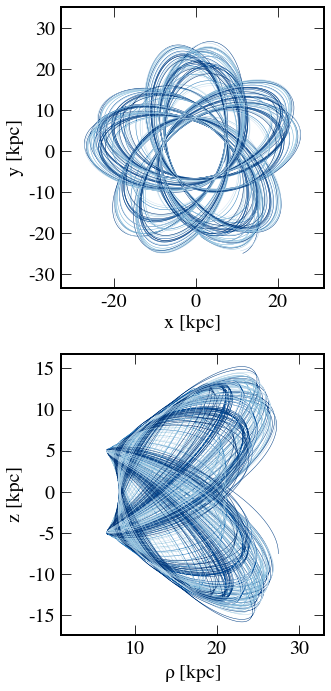

In [12]:
fig, ax = plt.subplots(2,1,figsize=(5,10))
np.random.seed(748)

for j in range(nplot):
    orbit = orbits[j]
    color = mpl.cm.Blues(np.random.random())

    plt.sca(ax[0])
    plt.plot(orbit.cartesian.x, orbit.cartesian.y, '-', color=color, lw=0.5)
    
    plt.sca(ax[1])
    plt.plot(orbit.cylindrical.rho, orbit.cartesian.z, '-', color=color, lw=0.5)
    
plt.sca(ax[0])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')

plt.sca(ax[1])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('$\\rho$ [kpc]')
plt.ylabel('z [kpc]')

plt.tight_layout()
plt.savefig('../plots/fig1_right.png')